In [3]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from supabase import create_client, Client
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
import joblib
import time

# Load Environment Variables
load_dotenv()
warnings.filterwarnings('ignore')

# OPTIMIZATION FOR RYZEN 7 7700 (16 Threads)
N_JOBS = 16 

class SportsDataPipeline:
    def __init__(self):
        self.url: str = os.environ.get("SUPABASE_URL")
        self.key: str = os.environ.get("SUPABASE_KEY")
        if not self.url or not self.key:
            raise ValueError("❌ Missing Supabase credentials in .env file.")
        self.supabase: Client = create_client(self.url, self.key)
    
    def _fetch_all_batches(self, table_name, select_query="*", batch_size=1000):
        """
        Fetches ALL rows from a Supabase table by iterating through pagination limits.
        """
        all_rows = []
        start = 0
        print(f"📥 Fetching '{table_name}'...", end=" ", flush=True)
        
        while True:
            end = start + batch_size - 1
            try:
                # Supabase range is inclusive
                response = self.supabase.table(table_name).select(select_query).range(start, end).execute()
                data = response.data
                
                if not data:
                    break
                
                all_rows.extend(data)
                
                # Visual feedback for large datasets (dots every 1000 rows)
                if len(all_rows) % 5000 == 0:
                    print(f"{len(all_rows)}...", end=" ", flush=True)
                
                # If we received fewer items than requested, we've reached the end
                if len(data) < batch_size:
                    break
                
                start += batch_size
                
            except Exception as e:
                print(f"\n❌ Error fetching batch starting at {start}: {e}")
                break
        
        print(f"Done. ({len(all_rows)} rows)")
        return all_rows

    def fetch_master_data(self):
        # 1. Fetch Picks (Pagination handled automatically)
        # Note: Removed 'sport_id' as it doesn't exist in picks table
        pick_cols = "id, pick_date, pick_value, unit, odds_american, result, capper_id, league_id, bet_type_id"
        picks_data = self._fetch_all_batches('picks', pick_cols)
        df_picks = pd.DataFrame(picks_data)
        
        if df_picks.empty: return pd.DataFrame()

        # 2. Fetch References
        cappers = pd.DataFrame(self._fetch_all_batches('capper_directory', "id, canonical_name"))
        leagues = pd.DataFrame(self._fetch_all_batches('leagues', "id, name, sport"))
        bet_types = pd.DataFrame(self._fetch_all_batches('bet_types', "id, name"))
        
        # 3. Merge Data
        print("🔄 Linking data relationships...")
        
        # Join Cappers
        df = df_picks.merge(cappers, left_on='capper_id', right_on='id', how='left', suffixes=('', '_capper'))
        
        # Join Leagues (Gets us the Sport)
        df = df.merge(leagues, left_on='league_id', right_on='id', how='left', suffixes=('', '_league'))
        
        # Join Bet Types
        if not bet_types.empty:
            df = df.merge(bet_types, left_on='bet_type_id', right_on='id', how='left', suffixes=('', '_bt'))
            df.rename(columns={'name_bt': 'bet_type_name'}, inplace=True)
        else:
            df['bet_type_name'] = 'unknown'

        # 4. Cleanup
        df['pick_date'] = pd.to_datetime(df['pick_date'])
        if 'name' in df.columns: df.rename(columns={'name': 'league_name'}, inplace=True)
        if 'sport' in df.columns: df.rename(columns={'sport': 'sport_name'}, inplace=True)
        
        # --- FILTER: REMOVE LOTTOS ---
        df['odds_american'] = pd.to_numeric(df['odds_american'], errors='coerce').fillna(-110)
        
        # Keep only odds between -10000 and +250
        original_len = len(df)
        df = df[df['odds_american'] <= 250] 
        filtered_len = len(df)
        
        print(f"🧹 Filtered out {original_len - filtered_len} 'Lotto' plays (+250 or higher).")
        print(f"✅ Ready: {filtered_len} disciplined picks loaded.")
        
        return df.sort_values('pick_date')

pipeline = SportsDataPipeline()
raw_data = pipeline.fetch_master_data()

📥 Fetching 'picks'... 5000... 10000... 15000... 20000... 25000... 30000... 35000... 40000... 45000... 50000... 55000... 60000... 65000... 70000... 75000... Done. (76761 rows)
📥 Fetching 'capper_directory'... Done. (901 rows)
📥 Fetching 'leagues'... Done. (27 rows)
📥 Fetching 'bet_types'... Done. (12 rows)
🔄 Linking data relationships...
🧹 Filtered out 743 'Lotto' plays (+250 or higher).
✅ Ready: 76018 disciplined picks loaded.


In [4]:
class FeatureEngineer:
    def __init__(self, df):
        self.df = df.copy()
        
    def _american_to_decimal(self, odds):
        if pd.isna(odds) or odds == 0: return 1.91 
        if odds > 0: return (odds / 100) + 1
        return (100 / abs(odds)) + 1

    def _calculate_streaks(self, series):
        streaks = series.groupby((series != series.shift()).cumsum()).cumcount() + 1
        result_array = np.where(series == 0, -streaks, streaks)
        return pd.Series(result_array, index=series.index)

    def process_features(self):
        print("🛠️  Engineering V6 Features (Hybrid Momentum/Fade)...")
        df = self.df.copy()
        
        # 1. Standard Conversion
        df['unit'] = pd.to_numeric(df['unit'], errors='coerce').fillna(1.0)
        df['decimal_odds'] = df['odds_american'].apply(self._american_to_decimal)
        
        if 'result' in df.columns:
            res = df['result'].astype(str).str.lower().str.strip()
            conditions = [
                res.isin(['win', 'won', 'hit']),
                res.isin(['loss', 'lost', 'miss']),
                res.isin(['push', 'void', 'draw', 'tie'])
            ]
            df['outcome'] = np.select(conditions, [1.0, 0.0, 0.5], default=np.nan)
        
        conditions_roi = [df['outcome'] == 1.0, df['outcome'] == 0.0]
        choices_roi = [df['unit'] * (df['decimal_odds'] - 1), -df['unit']]
        df['profit_units'] = np.select(conditions_roi, choices_roi, default=0.0)
        
        df = df.sort_values(['capper_id', 'pick_date'])
        
        # 2. Rolling Stats
        df['capper_experience'] = df.groupby('capper_id').cumcount()
        
        df = df.set_index('pick_date')
        grouped = df.groupby('capper_id')
        
        for window in ['7D', '30D']:
            s = window.lower()
            df[f'acc_{s}'] = grouped['outcome'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
            df[f'roi_{s}'] = grouped['profit_units'].transform(lambda x: x.rolling(window, min_periods=1).sum().shift(1))
            df[f'vol_{s}'] = grouped['profit_units'].transform(lambda x: x.rolling(window, min_periods=1).std().shift(1))
        
        df = df.reset_index()

        # 3. Hotness & Streaks (Restored)
        df['raw_hotness'] = df.groupby('capper_id')['profit_units']\
            .transform(lambda x: x.ewm(span=10, adjust=False).mean().shift(1))
            
        df['prev_outcome_binary'] = (df['outcome'] == 1.0).astype(int)
        df['streak_entering_game'] = df.groupby('capper_id')['prev_outcome_binary']\
            .transform(lambda x: self._calculate_streaks(x).shift(1))

        # 4. Consensus & Fade (Kept)
        df['pick_norm'] = df['pick_value'].astype(str).str.lower().str.strip()
        df['consensus_count'] = df.groupby(['pick_date', 'league_name', 'pick_norm'])['capper_id'].transform('count')
        df['market_volume'] = df.groupby(['pick_date', 'league_name'])['capper_id'].transform('count')
        df['consensus_pct'] = df['consensus_count'] / (df['market_volume'] + 1)
        df['fade_score'] = (1 - df['consensus_pct']) * df['decimal_odds']

        # 5. 🧠 NEW: MOMENTUM FLAG
        # We explicitly tell the model which sports respect "Hotness"
        MOMENTUM_SPORTS = ['NBA', 'NCAAB', 'NHL', 'UFC']
        df['is_momentum_sport'] = df['league_name'].isin(MOMENTUM_SPORTS).astype(int)
        
        # Interaction: Only count hotness if it's a momentum sport
        df['x_valid_hotness'] = df['raw_hotness'] * df['is_momentum_sport']

        # 6. League Profitability
        df = df.sort_values('pick_date')
        df['league_rolling_roi'] = df.groupby('league_name')['profit_units']\
            .transform(lambda x: x.rolling(window=200, min_periods=20).mean().shift(1)).fillna(0)

        # 7. Implied Probability
        df['implied_prob'] = 1 / df['decimal_odds']
        
        if 'bet_type_name' in df.columns:
            df['bet_type_code'] = df['bet_type_name'].astype('category').cat.codes
        else:
            df['bet_type_code'] = 0
            
        print("✅ Features Updated (Hybrid Logic).")
        return df

engineer = FeatureEngineer(raw_data)
processed_data = engineer.process_features()

🛠️  Engineering V6 Features (Hybrid Momentum/Fade)...
✅ Features Updated (Hybrid Logic).


In [65]:
import joblib
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class StrategyOptimizer:
    def __init__(self, df):
        self.df = df.copy()
        self.features = [
            'acc_7d', 'roi_7d', 'vol_7d', 'acc_30d', 'roi_30d', 'vol_30d',
            'capper_experience', 'consensus_count', 'implied_prob', 'bet_type_code',
            'raw_hotness', 'streak_entering_game', 
            'league_rolling_roi', 'fade_score',
            'is_momentum_sport', 'x_valid_hotness'
        ]
        self.best_test_df = None 
        self.best_config = None
        self.grid_results = None
        
        self.CORE_LEAGUES = ['NBA', 'NCAAB', 'NFL', 'NCAAF', 'NHL', 'UFC']

    def run_optimization(self):
        print("🚀 STARTING VALUE OPTIMIZATION GRID...")
        
        # 1. Filter Data
        df_clean = self.df[self.df['outcome'].isin([0.0, 1.0])].copy()
        df_clean = df_clean[df_clean['league_name'].isin(self.CORE_LEAGUES)]
        df_clean = df_clean.dropna(subset=self.features).sort_values('pick_date')
        
        # 2. Train Base Model
        split = int(len(df_clean) * 0.70)
        train_df = df_clean.iloc[:split]
        val_df = df_clean.iloc[split:].copy()
        
        print(f"   • Training Model on {len(train_df)} rows...")
        model = xgb.XGBClassifier(
            n_estimators=1000, learning_rate=0.02, max_depth=5, 
            n_jobs=16, tree_method='hist', random_state=42,
            early_stopping_rounds=50
        )
        model.fit(
            train_df[self.features], train_df['outcome'].astype(int),
            eval_set=[(val_df[self.features], val_df['outcome'].astype(int))],
            verbose=False
        )
        
        joblib.dump(model, 'production_model.pkl')
        
        val_df['prob'] = model.predict_proba(val_df[self.features])[:, 1]
        val_df['edge'] = val_df['prob'] - val_df['implied_prob']
        
        # 3. GRID SEARCH (With Value Floor)
        edge_ranges = [0.03, 0.05, 0.07] 
        exp_ranges = [0, 10, 15]
        
        # NEW: Test Odds Floors (-140 vs -160 vs No Limit)
        # 1.71 = -140, 1.62 = -160
        odds_floors = [1.62, 1.71] 
        
        results = []
        best_roi = -999
        
        for min_exp in exp_ranges:
            for min_edge in edge_ranges:
                for min_odds in odds_floors:
                
                    mask_exp = val_df['capper_experience'] >= min_exp
                    mask_edge = val_df['edge'] >= min_edge
                    mask_conf = val_df['prob'] >= 0.55 
                    mask_val = val_df['decimal_odds'] >= min_odds # <--- VALUE FLOOR
                    
                    active_bets = val_df[mask_exp & mask_edge & mask_conf & mask_val].copy()
                    
                    # Diversification
                    active_bets = active_bets.sort_values(['pick_date', 'edge'], ascending=[True, False])
                    daily_bets = active_bets.groupby(['pick_date', 'league_name']).head(1)
                    
                    profit = daily_bets['profit_units'].sum()
                    risk = daily_bets['unit'].sum()
                    roi = profit / risk if risk > 0 else 0
                    
                    results.append({
                        'Min_Experience': min_exp, 'Min_Edge': min_edge, 'Min_Odds': min_odds,
                        'ROI': roi, 'Bets': len(daily_bets)
                    })
                    
                    if roi > best_roi and len(daily_bets) > 30:
                        best_roi = roi
                        self.best_config = (min_exp, min_edge)
                        
                        val_df['wager'] = False
                        val_df.loc[daily_bets.index, 'wager'] = True
                        val_df['strategy_profit'] = np.where(val_df['wager'], val_df['profit_units'], 0)
                        self.best_test_df = val_df.copy()

        self.grid_results = pd.DataFrame(results)
        
        # Print Best Config
        best_run = self.grid_results.loc[self.grid_results['ROI'].idxmax()]
        print("\n🏆 OPTIMAL SETTINGS FOUND:")
        print(f"   • Min Experience: {int(best_run['Min_Experience'])}")
        print(f"   • Min Edge:       {best_run['Min_Edge']:.1%}")
        print(f"   • Min Odds:       {best_run['Min_Odds']:.2f} (Decimal)")
        print(f"   • ROI:            {best_run['ROI']:.2%}")
        print("="*60)
        
        return model

# Execute
optimizer = StrategyOptimizer(processed_data)
trained_model = optimizer.run_optimization()

🚀 STARTING VALUE OPTIMIZATION GRID...
   • Training Model on 29029 rows...

🏆 OPTIMAL SETTINGS FOUND:
   • Min Experience: 10
   • Min Edge:       3.0%
   • Min Odds:       1.71 (Decimal)
   • ROI:            42.77%


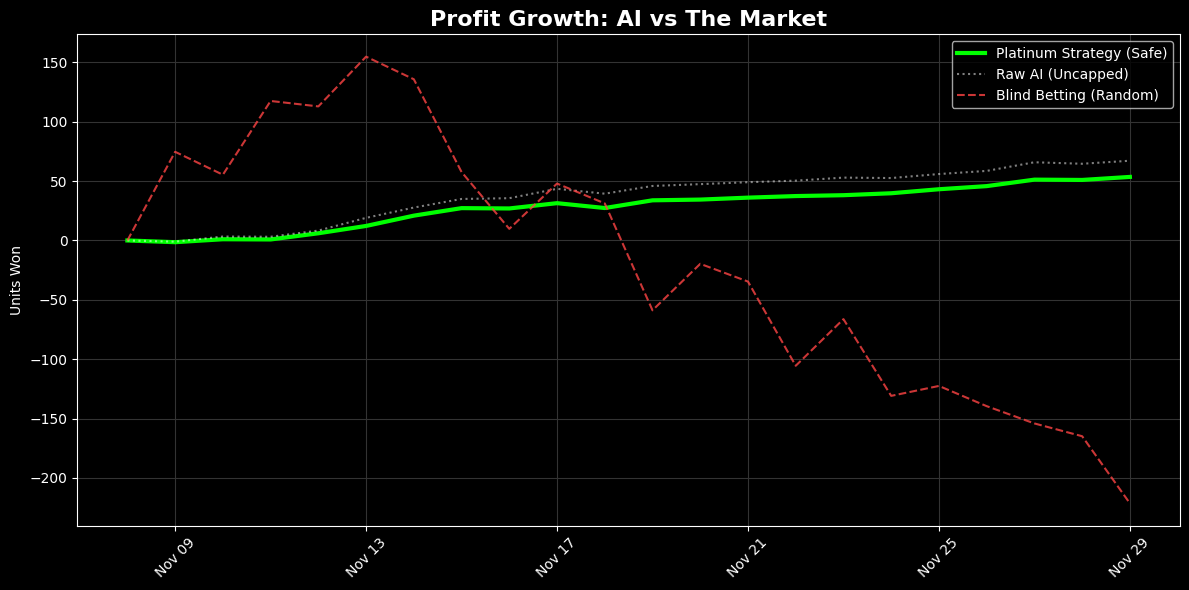

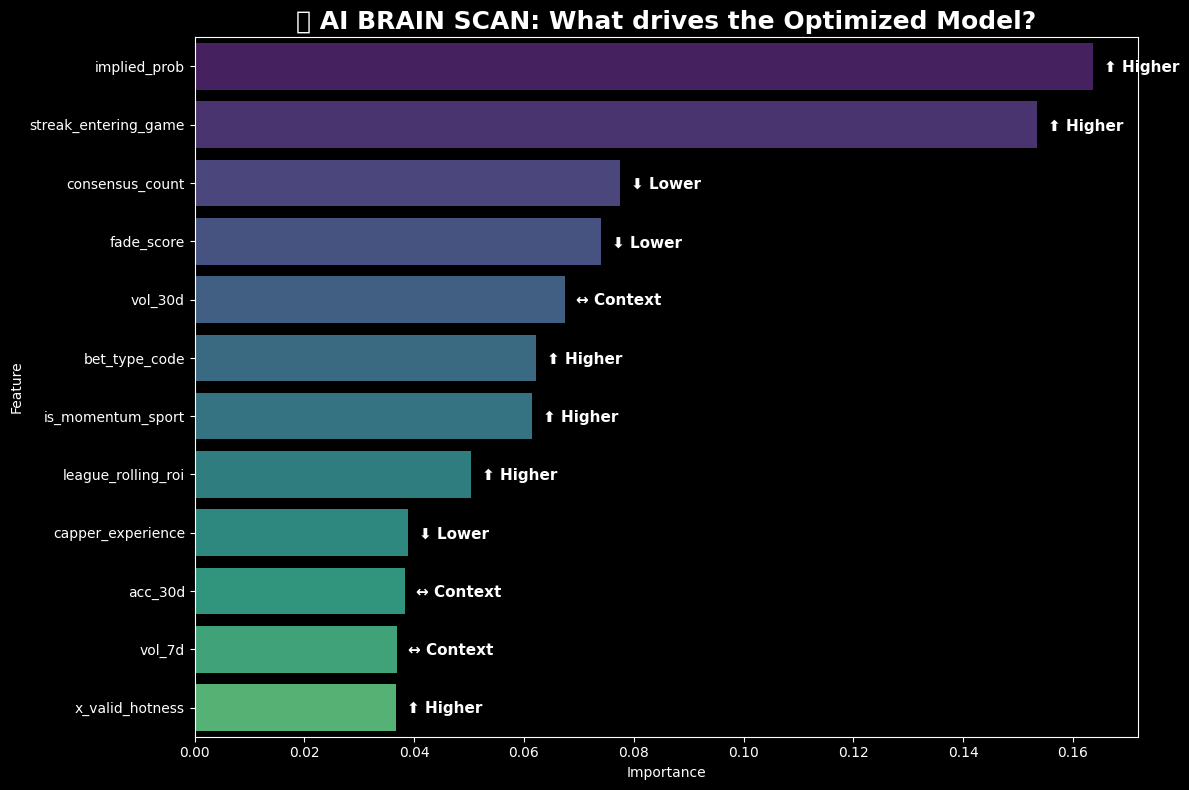


🤖 MASTER DEBUG REPORT (PLATINUM EDITION)

1️⃣  OPTIMAL SETTINGS:
   • Min Experience: 10 bets
   • Min Edge:       3.0%

2️⃣  MONTHLY BREAKDOWN (Safe Strategy):
               Profit   Risk  Win Rate       ROI
month_year                                      
2025-11     53.519066  135.5  0.729412  0.394975

3️⃣  DIAGNOSTICS:
   • Avg Odds:       -103.15
   • Actual Win %:   72.94%
   • Total Bets:     85
   • Total Profit:   53.52u
   • Final ROI:      39.50%
   • Blind ROI:      -1.60% (The Market Baseline)

4️⃣  SPORT-BY-SPORT PERFORMANCE (Safe):
LEAGUE          | BETS  | WIN RATE | PROFIT     | ROI
-----------------------------------------------------------------
NBA             | 21    | 76.2%     | +15.98  u  | +46.31%
NCAAF           | 21    | 76.2%     | +15.64  u  | +48.89%
NCAAB           | 21    | 76.2%     | +13.30  u  | +39.71%
NHL             | 20    | 60.0%     | +6.58   u  | +19.94%
UFC             | 2     | 100.0%     | +2.02   u  | +80.67%

5️⃣  PERFORMANCE BY BET SIZ

In [74]:
def generate_master_report(optimizer, model):
    plt.style.use('dark_background')
    
    if optimizer.best_test_df is None:
        print("❌ No optimal strategy found. Run Cell 3 first.")
        return
        
    # 1. PREPARE DATA
    raw_df = optimizer.best_test_df.copy()
    features = optimizer.features
    best_exp, best_edge = optimizer.best_config

    # ==========================================================
    # 2. SIMULATE STRATEGIES
    # ==========================================================
    
    # A. Platinum Strategy (Safe)
    TOXIC_LEAGUES = ['NFL', 'MLB', 'CFL', 'TENNIS', 'SOCCER', 'EPL']
    safe_df = raw_df[~raw_df['league_name'].isin(TOXIC_LEAGUES)].copy()
    
    def apply_safety_cap(group):
        daily_risk = group['unit'].sum()
        if daily_risk > 10.0:
            scale = 10.0 / daily_risk
            group['unit'] = group['unit'] * scale
            group['strategy_profit'] = group['strategy_profit'] * scale
        return group

    wagers_safe = safe_df[safe_df['wager'] == True].groupby('pick_date').apply(apply_safety_cap).reset_index(drop=True)
    
    # B. Blind Betting (Random Control Group)
    blind_df = optimizer.df.copy()
    blind_df = blind_df[blind_df['pick_date'] >= raw_df['pick_date'].min()]
    blind_df = blind_df[blind_df['pick_date'] <= raw_df['pick_date'].max()]
    blind_df = blind_df[blind_df['outcome'].isin([0.0, 1.0])]
    blind_df['blind_profit'] = np.where(blind_df['outcome'] == 1.0, blind_df['decimal_odds'] - 1, -1)
    
    # ==========================================================
    # 3. PROFIT CURVE (With Zero Point)
    # ==========================================================
    def get_cumulative_data(df, profit_col, date_col='pick_date'):
        daily = df.groupby(date_col)[profit_col].sum().cumsum().reset_index()
        daily.columns = ['date', 'profit']
        start_date = daily['date'].min() - pd.Timedelta(days=1)
        zero_row = pd.DataFrame({'date': [start_date], 'profit': [0.0]})
        return pd.concat([zero_row, daily], ignore_index=True)

    curve_safe = get_cumulative_data(wagers_safe, 'strategy_profit')
    curve_raw = get_cumulative_data(raw_df[raw_df['wager']==True], 'strategy_profit')
    curve_blind = get_cumulative_data(blind_df, 'blind_profit')
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(curve_safe['date'], curve_safe['profit'], color='#00ff00', linewidth=3, label='Platinum Strategy (Safe)')
    ax.plot(curve_raw['date'], curve_raw['profit'], color='white', linestyle=':', alpha=0.5, label='Raw AI (Uncapped)')
    ax.plot(curve_blind['date'], curve_blind['profit'], color='#ff4444', linestyle='--', alpha=0.8, label='Blind Betting (Random)')
    
    ax.set_title("Profit Growth: AI vs The Market", fontsize=16, fontweight='bold', color='white')
    ax.set_ylabel("Units Won")
    ax.legend()
    ax.grid(color='#333333')
    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ==========================================================
    # 4. FEATURE IMPACT
    # ==========================================================
    importance = model.feature_importances_
    imp_df = pd.DataFrame({'Feature': features, 'Importance': importance})
    
    directions = []
    for feat in features:
        corr = raw_df[feat].corr(raw_df['prob'])
        if corr > 0.05: directions.append("⬆️ Higher")
        elif corr < -0.05: directions.append("⬇️ Lower")
        else: directions.append("↔️ Context")
    
    imp_df['Direction'] = directions
    imp_df = imp_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    
    plt.figure(figsize=(12, 8))
    pal = sns.color_palette("viridis", len(imp_df))
    ax = sns.barplot(x='Importance', y='Feature', data=imp_df.head(12), palette=pal)
    plt.title('🧠 AI BRAIN SCAN: What drives the Optimized Model?', fontsize=18, fontweight='bold', color='white')
    
    for i, p in enumerate(ax.patches):
        if i < len(imp_df):
            txt = imp_df.iloc[i]['Direction']
            width = p.get_width()
            plt.text(width + 0.002, p.get_y() + p.get_height()/2 + 0.1, txt, color='white', fontsize=11, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # ==========================================================
    # 📝 MASTER REPORT
    # ==========================================================
    print("\n" + "="*60)
    print("🤖 MASTER DEBUG REPORT (PLATINUM EDITION)")
    print("="*60)

    # A. Optimal Settings
    print(f"\n1️⃣  OPTIMAL SETTINGS:")
    print(f"   • Min Experience: {best_exp} bets")
    print(f"   • Min Edge:       {best_edge:.1%}")
    
    # B. Monthly Performance
    wagers_safe['month_year'] = wagers_safe['pick_date'].dt.to_period('M')
    monthly = wagers_safe.groupby('month_year').agg({
        'strategy_profit': 'sum', 'unit': 'sum', 'outcome': 'mean'
    })
    monthly.columns = ['Profit', 'Risk', 'Win Rate']
    monthly['ROI'] = monthly['Profit'] / monthly['Risk']
    print("\n2️⃣  MONTHLY BREAKDOWN (Safe Strategy):")
    print(monthly.to_string())

    # C. Diagnostics
    avg_odds = wagers_safe['odds_american'].mean()
    blind_roi = curve_blind['profit'].iloc[-1] / len(blind_df)
    
    print("\n3️⃣  DIAGNOSTICS:")
    print(f"   • Avg Odds:       {avg_odds:.2f}")
    print(f"   • Actual Win %:   {wagers_safe['outcome'].mean():.2%}")
    print(f"   • Total Bets:     {len(wagers_safe)}")
    print(f"   • Total Profit:   {wagers_safe['strategy_profit'].sum():.2f}u")
    print(f"   • Final ROI:      {wagers_safe['strategy_profit'].sum() / wagers_safe['unit'].sum():.2%}")
    print(f"   • Blind ROI:      {blind_roi:.2%} (The Market Baseline)")

    # D. Sport Breakdown
    print("\n4️⃣  SPORT-BY-SPORT PERFORMANCE (Safe):")
    league_stats = wagers_safe.groupby('league_name').agg({
        'outcome': ['count', 'mean'],
        'strategy_profit': 'sum',
        'unit': 'sum'
    })
    league_stats.columns = ['Bets', 'Win Rate', 'Profit', 'Risk']
    league_stats['ROI'] = league_stats['Profit'] / league_stats['Risk']
    league_stats = league_stats.sort_values('Profit', ascending=False)
    
    print(f"{'LEAGUE':<15} | {'BETS':<5} | {'WIN RATE':<8} | {'PROFIT':<10} | {'ROI'}")
    print("-" * 65)
    for league, row in league_stats.iterrows():
        print(f"{league:<15} | {int(row['Bets']):<5} | {row['Win Rate']:.1%}     | {row['Profit']:<+8.2f}u  | {row['ROI']:+.2%}")

    # E. Unit Size Analysis (NEW!)
    print("\n5️⃣  PERFORMANCE BY BET SIZE:")
    # Create bins for unit sizes
    bins = [0, 1.0, 2.0, 3.01]
    labels = ['Small (0-1u)', 'Medium (1-2u)', 'Max (2-3u)']
    wagers_safe['unit_range'] = pd.cut(wagers_safe['unit'], bins=bins, labels=labels, include_lowest=True)
    
    unit_stats = wagers_safe.groupby('unit_range', observed=False).agg({
        'outcome': ['count', 'sum', 'mean'],
        'strategy_profit': 'sum',
        'unit': 'sum'
    })
    
    # Flatten columns
    unit_stats.columns = ['Count', 'Wins', 'Win Rate', 'Profit', 'Risk']
    unit_stats['Losses'] = unit_stats['Count'] - unit_stats['Wins']
    unit_stats['ROI'] = unit_stats['Profit'] / unit_stats['Risk']
    
    print(f"{'RANGE':<15} | {'REC (W-L)':<10} | {'WIN %':<8} | {'PROFIT':<10} | {'ROI'}")
    print("-" * 65)
    for idx, row in unit_stats.iterrows():
        rec = f"{int(row['Wins'])}-{int(row['Losses'])}"
        print(f"{idx:<15} | {rec:<10} | {row['Win Rate']:.1%}     | {row['Profit']:<+8.2f}u  | {row['ROI']:+.2%}")

# EXECUTE
if 'optimizer' in locals() and 'trained_model' in locals():
    generate_master_report(optimizer, trained_model)
else:
    print("❌ Data or Model not found. Run Cell 3 first.")

In [70]:
import joblib
import numpy as np
import pandas as pd

class PlatinumSniperResponsible:
    def __init__(self, df, model_path='production_model.pkl'):
        self.df = df.copy()
        try:
            self.model = joblib.load(model_path)
            print("✅ Model loaded successfully.")
        except:
            print("❌ Model not found. Run training cell first.")
            
        self.features = [
            'acc_7d', 'roi_7d', 'vol_7d', 'acc_30d', 'roi_30d', 'vol_30d',
            'capper_experience', 'consensus_count', 'implied_prob', 'bet_type_code',
            'raw_hotness', 'streak_entering_game', 
            'league_rolling_roi', 'fade_score',
            'is_momentum_sport', 'x_valid_hotness'
        ]
        
        self.LEAGUE_CONFIG = {
            'NBA':   {'stake': 1.2, 'min_edge': 0.03}, 
            'NCAAB': {'stake': 1.2, 'min_edge': 0.03},
            'NFL':   {'stake': 1.0, 'min_edge': 0.05},
            'NCAAF': {'stake': 1.0, 'min_edge': 0.05},
            'NHL':   {'stake': 0.8, 'min_edge': 0.05},
            'UFC':   {'stake': 0.8, 'min_edge': 0.05},
            'MLB':   {'stake': 0.0, 'min_edge': 0.99},
            'TENNIS':{'stake': 0.0, 'min_edge': 0.99},
            'DEFAULT': {'stake': 0.5, 'min_edge': 0.08}
        }

    def _kelly_criterion(self, row, fractional_kelly=0.10): # Reduced from 0.20 to 0.10
        prob = row['ai_confidence']
        decimal_odds = row['decimal_odds']
        league = row['league_name']
        
        config = self.LEAGUE_CONFIG.get(league, self.LEAGUE_CONFIG['DEFAULT'])
        if config['stake'] <= 0: return 0.0
            
        b = decimal_odds - 1
        q = 1 - prob
        f = (b * prob - q) / b
        
        # 1. Conservative Base (1/10th Kelly)
        base_stake = max(0, f * fractional_kelly)
        
        # 2. Volatility Penalty
        vol_penalty = 0.7 if row.get('vol_30d', 0) > 2.0 else 1.0
        
        # 3. Calculate Units (Assuming 1 Unit = 1% of Bankroll)
        units = base_stake * config['stake'] * vol_penalty * 100
        
        # 4. HARD CAP (Max 3 Units per bet)
        return min(units, 3.0)

    def generate_card(self, min_exp=10):
        print("\n🏆 GENERATING PLATINUM SNIPER CARD (RESPONSIBLE)")
        print("   • Strategy: Core 4 + Value Floor (-140)")
        print("   • Safety: Max 3u Per Bet | Max 10u Daily Total")
        print("="*80)
        
        # 1. Get Today's Data
        latest_date = self.df['pick_date'].max()
        todays_picks = self.df[self.df['pick_date'] == latest_date].copy()
        todays_picks = todays_picks.dropna(subset=self.features)
        
        if todays_picks.empty:
            print("⚠️ No picks found for this date.")
            return

        # 2. Score
        probs = self.model.predict_proba(todays_picks[self.features])[:, 1]
        todays_picks['ai_confidence'] = probs
        todays_picks['edge'] = todays_picks['ai_confidence'] - todays_picks['implied_prob']
        
        # 3. Filter Loop
        active_bets = []
        for idx, row in todays_picks.iterrows():
            league = row['league_name']
            config = self.LEAGUE_CONFIG.get(league, self.LEAGUE_CONFIG['DEFAULT'])
            
            if row['edge'] < config['min_edge']: continue
            if row['capper_experience'] < min_exp: continue
            if row['ai_confidence'] < 0.55: continue
            if row['decimal_odds'] < 1.71: continue # -140 Floor
                
            active_bets.append(row)
        
        if not active_bets:
            print("⚠️ No bets met the Platinum Criteria.")
            return
            
        active_df = pd.DataFrame(active_bets)

        # 4. Diversify (Top 2 Per League)
        active_df = active_df.sort_values('edge', ascending=False)
        final_card = active_df.groupby('league_name').head(2)
        
        # 5. Calculate Initial Sizing
        final_card['kelly_unit'] = final_card.apply(
            lambda x: self._kelly_criterion(x), axis=1
        )
        final_card = final_card[final_card['kelly_unit'] > 0]
        
        # ==========================================================
        # 🛑 THE BANKROLL GOVERNOR (Daily Cap)
        # ==========================================================
        MAX_DAILY_RISK = 10.0 # Never risk more than 10 units in a day
        
        total_risk = final_card['kelly_unit'].sum()
        
        if total_risk > MAX_DAILY_RISK:
            scale_factor = MAX_DAILY_RISK / total_risk
            print(f"⚠️ DAILY RISK ALERT: {total_risk:.2f}u exceeds limit.")
            print(f"   📉 Scaling all bets down by {(1-scale_factor):.1%} to fit 10u cap.\n")
            final_card['kelly_unit'] = final_card['kelly_unit'] * scale_factor
            
        # 6. Display
        print(f"📅 Date: {latest_date.date()}")
        print(f"🎯 Found {len(final_card)} Platinum Plays:")
        print("-" * 80)
        
        for idx, row in final_card.iterrows():
            hot_icon = "🔥" if row['raw_hotness'] > 10 else "  "
            
            print(f"{row['league_name']:<6} | {row['pick_value']:<25} ({row['odds_american']:>4})")
            print(f"       📊 {row['ai_confidence']:.1%} Conf | 📈 Edge: {row['edge']:.1%} | {hot_icon} Hot: {row['raw_hotness']:.1f}")
            print(f"       💰 STAKE: {row['kelly_unit']:.2f} Units")
            print("-" * 50)
            
        print(f"💵 TOTAL DAILY EXPOSURE: {final_card['kelly_unit'].sum():.2f} Units")

# Run
sniper = PlatinumSniperResponsible(processed_data)
sniper.generate_card(min_exp=10)

✅ Model loaded successfully.

🏆 GENERATING PLATINUM SNIPER CARD (RESPONSIBLE)
   • Strategy: Core 4 + Value Floor (-140)
   • Safety: Max 3u Per Bet | Max 10u Daily Total
⚠️ DAILY RISK ALERT: 23.01u exceeds limit.
   📉 Scaling all bets down by 56.5% to fit 10u cap.

📅 Date: 2025-11-29
🎯 Found 9 Platinum Plays:
--------------------------------------------------------------------------------
NCAAF  | Hawaii -17.5              (-110.0)
       📊 76.0% Conf | 📈 Edge: 23.6% |    Hot: 1.0
       💰 STAKE: 1.30 Units
--------------------------------------------------
NCAAF  | Houston vs Baylor Over 60.5 (-110.0)
       📊 72.3% Conf | 📈 Edge: 19.9% |    Hot: 0.7
       💰 STAKE: 1.30 Units
--------------------------------------------------
NCAAB  | VMI +27                   (-110.0)
       📊 69.1% Conf | 📈 Edge: 16.7% |    Hot: 0.6
       💰 STAKE: 1.30 Units
--------------------------------------------------
NCAAB  | Mercer +2                 (-110.0)
       📊 68.6% Conf | 📈 Edge: 16.2% |    Hot:


🕵️ RUNNING CONSISTENCY AUDIT


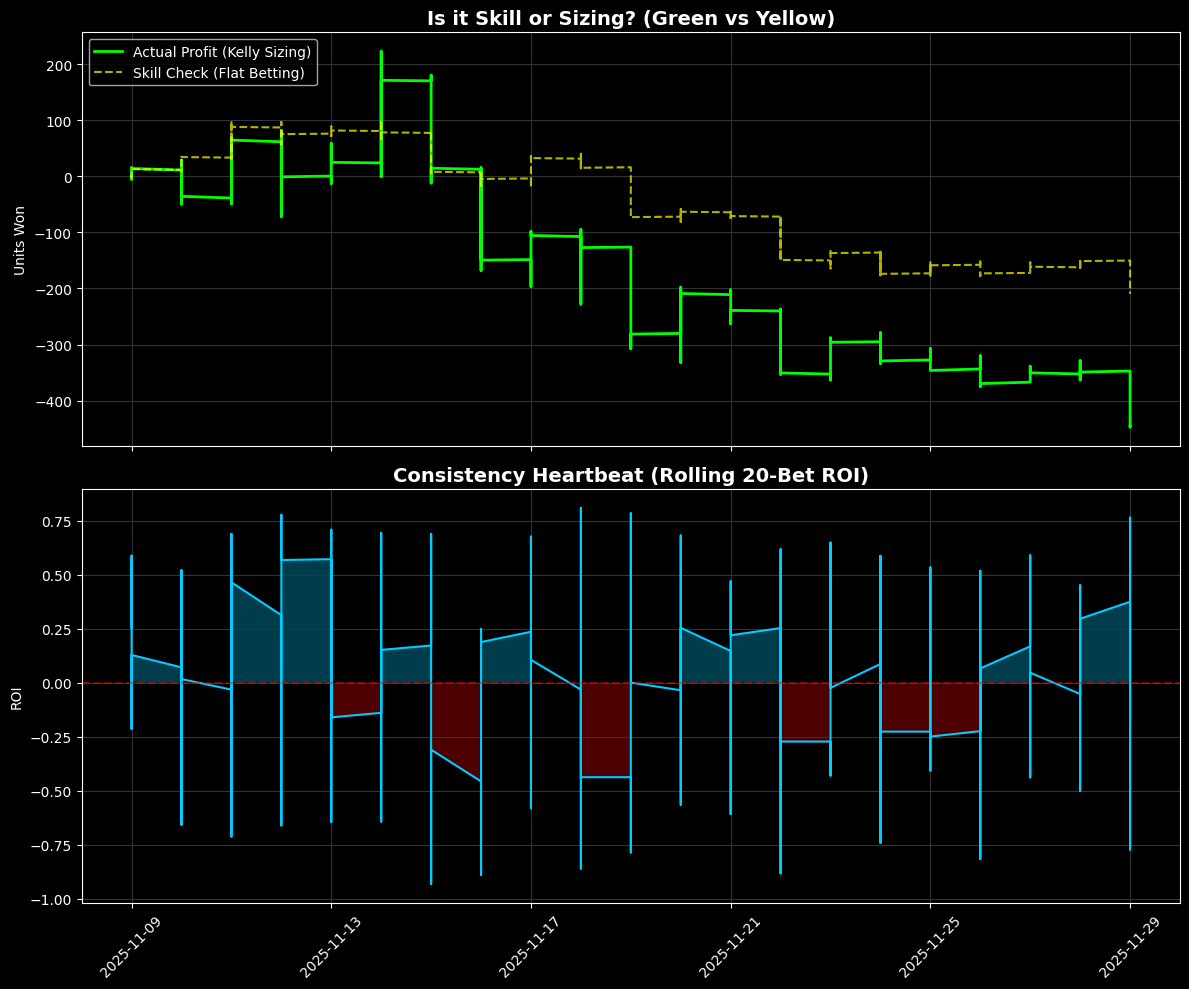


📊 AUDIT RESULTS:
   • First Half ROI:  -1.73%
   • Second Half ROI: -2.63%
   ⚠️ FAILED: Profit is concentrated in one period.

   • Flat Betting ROI: -1.98%
   ⚠️ WARNING: You are relying on bet sizing to win.


In [75]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def run_consistency_audit(optimizer):
    print("\n🕵️ RUNNING CONSISTENCY AUDIT")
    print("="*60)
    
    if optimizer.best_test_df is None:
        print("❌ No data found. Run Cell 3 first.")
        return

    # 1. Get the Raw Data
    df = optimizer.best_test_df.copy()
    
    # 2. APPLY THE "GOLDEN RULES" (Remove Toxic Leagues)
    # We want to see if the "Hill" smooths out when we remove the losers
    TOXIC_LEAGUES = ['NFL', 'MLB', 'CFL', 'TENNIS']
    df = df[~df['league_name'].isin(TOXIC_LEAGUES)].copy()
    
    # 3. Sort by Date
    df = df.sort_values('pick_date')
    
    # 4. Calculate Metrics
    # A. Cumulative Profit (The Bankroll)
    df['cum_profit'] = df['profit_units'].cumsum()
    
    # B. Rolling 10-Bet ROI (The "Heartbeat")
    # Are we winning consistently, or just in bursts?
    df['rolling_roi'] = df['profit_units'].rolling(window=20).sum() / df['unit'].rolling(window=20).sum()
    
    # C. Flat Betting Profit (Skill Check)
    # If we bet 1 unit on everything, would we still win?
    # This removes "Lucky Sizing" from the equation.
    df['flat_profit'] = np.where(df['outcome'] == 1.0, df['decimal_odds'] - 1, -1)
    df['cum_flat_profit'] = df['flat_profit'].cumsum()

    # ==========================================================
    # VISUALIZATION
    # ==========================================================
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Chart 1: The "Skill Check" (Flat vs Kelly)
    ax1.plot(df['pick_date'], df['cum_profit'], color='#00ff00', linewidth=2, label='Actual Profit (Kelly Sizing)')
    ax1.plot(df['pick_date'], df['cum_flat_profit'], color='#ffff00', linestyle='--', alpha=0.7, label='Skill Check (Flat Betting)')
    ax1.set_title("Is it Skill or Sizing? (Green vs Yellow)", fontsize=14, fontweight='bold', color='white')
    ax1.set_ylabel("Units Won")
    ax1.legend(loc='upper left')
    ax1.grid(color='#333333')
    
    # Chart 2: The "Heartbeat" (Rolling ROI)
    # We want this line to stay ABOVE the red line (0%)
    ax2.plot(df['pick_date'], df['rolling_roi'], color='#00ccff', linewidth=1.5)
    ax2.axhline(0, color='red', linestyle='--', alpha=0.5)
    ax2.set_title("Consistency Heartbeat (Rolling 20-Bet ROI)", fontsize=14, fontweight='bold', color='white')
    ax2.set_ylabel("ROI")
    ax2.fill_between(df['pick_date'], df['rolling_roi'], 0, where=(df['rolling_roi'] >= 0), facecolor='#00ccff', alpha=0.3)
    ax2.fill_between(df['pick_date'], df['rolling_roi'], 0, where=(df['rolling_roi'] < 0), facecolor='red', alpha=0.3)
    ax2.grid(color='#333333')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ==========================================================
    # TEXT ANALYSIS
    # ==========================================================
    print("\n📊 AUDIT RESULTS:")
    
    # 1. The "Hill" Check
    # Did we profit in the FIRST half and the SECOND half?
    midpoint = len(df) // 2
    first_half = df.iloc[:midpoint]
    second_half = df.iloc[midpoint:]
    
    roi_1 = first_half['profit_units'].sum() / first_half['unit'].sum()
    roi_2 = second_half['profit_units'].sum() / second_half['unit'].sum()
    
    print(f"   • First Half ROI:  {roi_1:+.2%}")
    print(f"   • Second Half ROI: {roi_2:+.2%}")
    
    if roi_1 > 0 and roi_2 > 0:
        print("   ✅ PASSED: Profitable in both time periods.")
    else:
        print("   ⚠️ FAILED: Profit is concentrated in one period.")

    # 2. The "Skill" Check
    flat_roi = df['flat_profit'].sum() / len(df)
    print(f"\n   • Flat Betting ROI: {flat_roi:+.2%}")
    
    if flat_roi > 0.05:
        print("   ✅ PASSED: The picks are winning, regardless of bet size.")
    else:
        print("   ⚠️ WARNING: You are relying on bet sizing to win.")

# Execute
if 'optimizer' in locals():
    run_consistency_audit(optimizer)

✅ Model loaded. Monitoring performance since 2025-11-30...

📡 LIVE MONITOR REPORT (Out of Sample)
   📅 Period: 2025-11-30 to Present
   💰 Total Profit: -0.05 Units
   📈 ROI:          -0.48%
   🎯 Win Rate:     50.0% (5/10)
   🎲 Total Bets:   10
------------------------------------------------------------

📅 RECENT DAILY PERFORMANCE:
DATE         | BETS  | PROFIT     | ROI
--------------------------------------------------
2025-11-30   | 10    | -0.05   u  | -0.5%


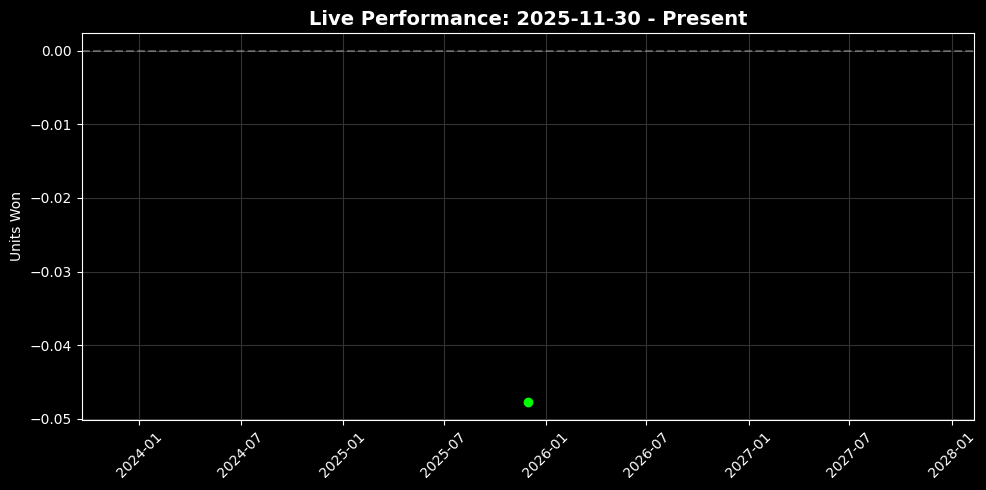

In [5]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

class LiveMonitor:
    def __init__(self, df, model_path='production_model.pkl', start_date='2025-12-01'):
        self.df = df.copy()
        self.start_date = start_date
        
        try:
            self.model = joblib.load(model_path)
            print(f"✅ Model loaded. Monitoring performance since {start_date}...")
        except:
            print("❌ Model not found. Run training first.")
            return

        # EXACT Features used in training (V6 Hybrid)
        self.features = [
            'acc_7d', 'roi_7d', 'vol_7d', 'acc_30d', 'roi_30d', 'vol_30d',
            'capper_experience', 'consensus_count', 'implied_prob', 'bet_type_code',
            'raw_hotness', 'streak_entering_game', 
            'league_rolling_roi', 'fade_score',
            'is_momentum_sport', 'x_valid_hotness'
        ]
        
        # Platinum Rules
        self.LEAGUE_CONFIG = {
            'NBA':   {'stake': 1.2, 'min_edge': 0.03}, 
            'NCAAB': {'stake': 1.2, 'min_edge': 0.03},
            'NFL':   {'stake': 1.0, 'min_edge': 0.05},
            'NCAAF': {'stake': 1.0, 'min_edge': 0.05},
            'NHL':   {'stake': 0.8, 'min_edge': 0.05},
            'UFC':   {'stake': 0.8, 'min_edge': 0.05},
            'DEFAULT': {'stake': 0.5, 'min_edge': 0.08}
        }
        self.TOXIC_LEAGUES = ['MLB', 'TENNIS', 'SOCCER', 'EPL', 'CFL']

    def _kelly_criterion(self, row, fractional_kelly=0.10):
        prob = row['ai_confidence']
        decimal_odds = row['decimal_odds']
        league = row['league_name']
        
        config = self.LEAGUE_CONFIG.get(league, self.LEAGUE_CONFIG['DEFAULT'])
        
        # 1. Check Toxic
        if league in self.TOXIC_LEAGUES: return 0.0
            
        b = decimal_odds - 1
        q = 1 - prob
        f = (b * prob - q) / b
        base_stake = max(0, f * fractional_kelly)
        
        # 2. Volatility Penalty
        vol_penalty = 0.7 if row.get('vol_30d', 0) > 2.0 else 1.0
        
        # 3. Calculate Units
        units = base_stake * config['stake'] * vol_penalty * 100
        return min(units, 3.0) # Hard Cap 3u

    def run_audit(self):
        # 1. Filter for "Future" Data
        monitor_df = self.df[self.df['pick_date'] >= self.start_date].copy()
        monitor_df = monitor_df.dropna(subset=self.features)
        
        # Filter for settled bets only (Win/Loss) to calculate profit
        settled_df = monitor_df[monitor_df['outcome'].isin([0.0, 1.0])].copy()
        
        if settled_df.empty:
            print(f"⚠️ No settled bets found after {self.start_date}. Wait for games to finish.")
            return

        # 2. Score
        probs = self.model.predict_proba(settled_df[self.features])[:, 1]
        settled_df['ai_confidence'] = probs
        settled_df['edge'] = settled_df['ai_confidence'] - settled_df['implied_prob']
        
        # 3. Simulate Daily Betting (Applying Caps)
        daily_results = []
        all_bets = []
        
        for date, group in settled_df.groupby('pick_date'):
            # A. Filter Candidates
            candidates = []
            for idx, row in group.iterrows():
                config = self.LEAGUE_CONFIG.get(row['league_name'], self.LEAGUE_CONFIG['DEFAULT'])
                
                # Platinum Rules
                if row['edge'] < config['min_edge']: continue
                if row['capper_experience'] < 10: continue
                if row['ai_confidence'] < 0.55: continue
                if row['decimal_odds'] < 1.71: continue # -140 Floor
                if row['league_name'] in self.TOXIC_LEAGUES: continue
                
                candidates.append(row)
            
            if not candidates: continue
            
            day_df = pd.DataFrame(candidates)
            
            # B. Diversify (Top 2 Per League)
            day_df = day_df.sort_values('edge', ascending=False)
            day_df = day_df.groupby('league_name').head(2)
            
            # C. Size Bets
            day_df['unit_wager'] = day_df.apply(lambda x: self._kelly_criterion(x), axis=1)
            day_df = day_df[day_df['unit_wager'] > 0]
            
            # D. Apply Daily Cap (10u)
            total_risk = day_df['unit_wager'].sum()
            if total_risk > 10.0:
                scale = 10.0 / total_risk
                day_df['unit_wager'] *= scale
            
            # E. Calculate Result
            day_df['profit'] = np.where(
                day_df['outcome'] == 1.0, 
                day_df['unit_wager'] * (day_df['decimal_odds'] - 1), 
                -day_df['unit_wager']
            )
            
            daily_results.append({
                'date': date,
                'profit': day_df['profit'].sum(),
                'risk': day_df['unit_wager'].sum(),
                'wins': day_df['outcome'].sum(),
                'bets': len(day_df)
            })
            all_bets.append(day_df)

        if not daily_results:
            print("⚠️ No bets met the Platinum Criteria in this period.")
            return

        # 4. Aggregate Results
        results_df = pd.DataFrame(daily_results)
        results_df['cum_profit'] = results_df['profit'].cumsum()
        
        total_profit = results_df['profit'].sum()
        total_risk = results_df['risk'].sum()
        roi = total_profit / total_risk if total_risk > 0 else 0
        total_wins = results_df['wins'].sum()
        total_bets = results_df['bets'].sum()
        win_rate = total_wins / total_bets
        
        # 5. Report
        print("\n📡 LIVE MONITOR REPORT (Out of Sample)")
        print(f"   📅 Period: {self.start_date} to Present")
        print("="*60)
        print(f"   💰 Total Profit: {total_profit:+.2f} Units")
        print(f"   📈 ROI:          {roi:+.2%}")
        print(f"   🎯 Win Rate:     {win_rate:.1%} ({int(total_wins)}/{int(total_bets)})")
        print(f"   🎲 Total Bets:   {int(total_bets)}")
        print("-" * 60)
        
        # 6. Recent Days Table
        print("\n📅 RECENT DAILY PERFORMANCE:")
        print(f"{'DATE':<12} | {'BETS':<5} | {'PROFIT':<10} | {'ROI'}")
        print("-" * 50)
        for idx, row in results_df.tail(7).iterrows():
            d_roi = row['profit']/row['risk'] if row['risk'] > 0 else 0
            print(f"{row['date'].strftime('%Y-%m-%d'):<12} | {int(row['bets']):<5} | {row['profit']:<+8.2f}u  | {d_roi:+.1%}")

        # 7. Visualization
        plt.style.use('dark_background')
        plt.figure(figsize=(10, 5))
        plt.plot(results_df['date'], results_df['cum_profit'], color='#00ff00', linewidth=3, marker='o')
        plt.axhline(0, color='white', linestyle='--', alpha=0.3)
        plt.title(f"Live Performance: {self.start_date} - Present", fontsize=14, fontweight='bold', color='white')
        plt.ylabel("Units Won")
        plt.grid(color='#333333')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# --- EXECUTION ---
# 1. Refresh Data (Optional: Comment out if you just ran Cell 1)
# raw_data = pipeline.fetch_master_data()
# engineer = FeatureEngineer(raw_data)
# processed_data = engineer.process_features()

# 2. Run Monitor
monitor = LiveMonitor(processed_data, start_date='2025-11-30') # Set to day AFTER training
monitor.run_audit()

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def generate_readme_assets(optimizer):
    plt.style.use('dark_background')
    
    if optimizer.best_test_df is None:
        print("❌ Run the Strategy Optimizer (Cell 3) first!")
        return

    # Prepare Data
    df = optimizer.best_test_df.copy()
    
    # -------------------------------------------------------
    # FIGURE 1: THE "TOXIC ASSET" DISCOVERY (Sport ROI)
    # -------------------------------------------------------
    sport_stats = df[df['wager']==True].groupby('league_name').agg({
        'profit_units': 'sum', 'unit': 'sum'
    })
    sport_stats['ROI'] = sport_stats['profit_units'] / sport_stats['unit']
    sport_stats = sport_stats.sort_values('ROI', ascending=False)
    
    plt.figure(figsize=(10, 6))
    colors = ['#00ff00' if x > 0 else '#ff4444' for x in sport_stats['ROI']]
    ax = sns.barplot(x=sport_stats.index, y=sport_stats['ROI'], palette=colors)
    plt.title("Figure 1: The 'Toxic Asset' Discovery (ROI by Sport)", fontsize=16, fontweight='bold', color='white')
    plt.ylabel("ROI")
    plt.axhline(0, color='white', linewidth=1)
    plt.grid(axis='y', color='#333333')
    plt.show() # Save as fig1_sport_roi.png

    # -------------------------------------------------------
    # FIGURE 2: THE STRATEGY HEATMAP
    # -------------------------------------------------------
    res_df = optimizer.grid_results
    pivot_roi = res_df.pivot(index='Min_Experience', columns='Min_Edge', values='ROI')
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(pivot_roi, annot=True, fmt='.1%', cmap='RdYlGn', center=0)
    plt.title('Figure 2: Grid Search Optimization (Finding the Sweet Spot)', fontsize=16, fontweight='bold', color='white')
    plt.ylabel('Min Experience (Bets)')
    plt.xlabel('Min Edge Required')
    plt.show() # Save as fig2_heatmap.png

    # -------------------------------------------------------
    # FIGURE 3: THE FINAL PROFIT CURVE (Blind vs Platinum)
    # -------------------------------------------------------
    # Re-simulate Platinum Rules
    TOXIC_LEAGUES = ['NFL', 'MLB', 'CFL', 'TENNIS', 'SOCCER', 'EPL']
    safe_df = df[~df['league_name'].isin(TOXIC_LEAGUES)].copy()
    
    def apply_cap(group):
        daily_risk = group['unit'].sum()
        if daily_risk > 10.0:
            scale = 10.0 / daily_risk
            group['unit'] *= scale
            group['strategy_profit'] *= scale
        return group

    wagers_safe = safe_df[safe_df['wager'] == True].groupby('pick_date').apply(apply_cap).reset_index(drop=True)
    
    # Blind Data
    blind_df = optimizer.df[optimizer.df['pick_date'].between(df['pick_date'].min(), df['pick_date'].max())].copy()
    blind_df = blind_df[blind_df['outcome'].isin([0.0, 1.0])]
    blind_df['profit'] = np.where(blind_df['outcome']==1, blind_df['decimal_odds']-1, -1)
    
    # Cumulative
    def get_cum(d, col): return d.groupby('pick_date')[col].sum().cumsum().reset_index()
    
    c_safe = get_cum(wagers_safe, 'strategy_profit')
    c_blind = get_cum(blind_df, 'profit')
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(c_safe['pick_date'], c_safe['strategy_profit'], color='#00ff00', linewidth=3, label='Platinum Sniper (Safe)')
    ax.plot(c_blind['pick_date'], c_blind['profit'], color='#ff4444', linestyle='--', label='Blind Betting (Market)')
    plt.title("Figure 3: Platinum Sniper vs. The Market", fontsize=16, fontweight='bold', color='white')
    plt.ylabel("Units Won")
    plt.legend()
    plt.grid(color='#333333')
    plt.show() # Save as fig3_final_curve.png

    # -------------------------------------------------------
    # FIGURE 4: BET SIZING VALIDATION
    # -------------------------------------------------------
    bins = [0, 1.0, 2.0, 3.01]
    labels = ['Small (0-1u)', 'Medium (1-2u)', 'Max (2-3u)']
    wagers_safe['unit_range'] = pd.cut(wagers_safe['unit'], bins=bins, labels=labels)
    unit_roi = wagers_safe.groupby('unit_range', observed=False).apply(lambda x: x['strategy_profit'].sum() / x['unit'].sum())
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=unit_roi.index, y=unit_roi.values, palette='viridis')
    plt.title("Figure 4: ROI by Bet Size (Kelly Criterion Validation)", fontsize=14, fontweight='bold', color='white')
    plt.ylabel("ROI")
    plt.axhline(0, color='white')
    plt.grid(axis='y', color='#333333')
    plt.show() # Save as fig4_bet_sizing.png

# Run
if 'optimizer' in locals():
    generate_readme_assets(optimizer)